<a href="https://colab.research.google.com/github/hiimkhang/dog_breed_classification/blob/main/10classes_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get dataset

In [1]:
import requests
import zipfile
import os

zip_file_path = "dog_breed_classification/small_dataset.zip"
data_dir = "dog_breed_classification/10classes_dataset"

if not os.path.isdir(data_dir):
    !git clone https://github.com/hiimkhang/dog_breed_classification
    # with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    #     zip_ref.extractall()


Cloning into 'dog_breed_classification'...
remote: Enumerating objects: 1958, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1958 (delta 4), reused 17 (delta 4), pack-reused 1941
Receiving objects: 100% (1958/1958), 75.96 MiB | 11.22 MiB/s, done.
Resolving deltas: 100% (5/5), done.


# Customize ResNet50 module

In [2]:
import torch
from torch import Tensor
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Optional
from torch.quantization import QuantStub, DeQuantStub


try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url


model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        self.skip_add = nn.quantized.FloatFunctional()

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        #out += identity
        out = self.skip_add.add(out, identity)
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.skip_add = nn.quantized.FloatFunctional()

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        #out += identity
        out = self.skip_add.add(out, identity)
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.quant(x) # add quant
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.dequant(x) # add dequant

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet50_quantizable(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

# Prepare dataloader

In [3]:
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

from torch.utils.data import DataLoader

from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms
import os

import time

root = data_dir
img_size = 224

train_batch_size = 8
eval_batch_size = 8
num_workers = 2
num_epochs = 10

loss_fn = torch.nn.CrossEntropyLoss()

train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225)),
    ])

test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225)),
    ])

train_set = datasets.ImageFolder(root=os.path.join(root, 'train'), transform=train_transform)
test_set = datasets.ImageFolder(root=os.path.join(root, 'valid'), transform=test_transform)

train_sampler = torch.utils.data.RandomSampler(train_set)
test_sampler = torch.utils.data.SequentialSampler(test_set)

train_loader = DataLoader(dataset=train_set,
                        batch_size=train_batch_size,
                        sampler=train_sampler,
                        num_workers=num_workers)

test_loader = DataLoader(dataset=test_set,
                        batch_size=eval_batch_size,
                        sampler=test_sampler,
                        num_workers=num_workers)

In [4]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")

In [6]:
batch_inputs, batch_targets = next(iter(train_loader))

in_channels = batch_inputs.shape[1]     # number of channels of input images
out_features = len(train_set.classes)

print("Input tensor shape:", batch_inputs.shape)
print("Number of classes (out_features):", out_features)
print("in_channels: ", in_channels)

Input tensor shape: torch.Size([8, 3, 224, 224])
Number of classes (out_features): 10
in_channels:  3


# Helper training functions
- modifyLayers
- train_step
- eval_step
- train_model

In [7]:
def modifyLayers(model: torch.nn.Module, in_channels: int, out_features: int):
    # modify the first convolutional layer, in_channels = input tensor channels
    model.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # modify the last fc layer, out_features = number of classes
    model.fc = torch.nn.Linear(model.fc.in_features, out_features)

In [8]:
def test(model: torch.nn.Module, loaders: DataLoader):
    # Test the model
    model.to('cpu')
    model.eval()
    accuracy = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in tqdm(loaders, total=len(loaders)):
            images = images.to('cpu')
            labels = labels.to('cpu')

            # Quantize the input data (images)
            # images_quantized = torch.quantization.quantize_data(images, scale=1.0, zero_point=0, dtype=torch.quint8)
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

    print(f"Test Accuracy of the model on the {len(loaders) * loaders.batch_size} test images: {accuracy:.2f}")


In [9]:
def train_step(model: nn.Module,
               train_loader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> tuple[float, float]:
    model.to(device)
    model.train()

    train_loss, train_accuracy = 0., 0.

    for batch, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)

        label_pred = model(image) # forward pass

        loss = loss_fn(label_pred, label) # compute loss
        train_loss += loss.item()

        optimizer.zero_grad() # zero param gradients

        loss.backward() # backward pass

        optimizer.step() # update parameters

        y_pred_labels = torch.argmax(torch.softmax(label_pred, dim=1), dim=1) # compute accuracy
        train_accuracy += (y_pred_labels == label).sum().item() / len(label_pred)

    avg_loss, avg_acc = train_loss/len(train_loader), train_accuracy/len(train_loader)
    print(f"Train loss: {avg_loss:.4f} | Train accuracy: {avg_acc:.4f}", end=' | ')

    return avg_loss, avg_acc

In [10]:
def eval_step(model: nn.Module,
              test_loader: DataLoader,
              loss_fn: nn.Module,
              device: torch.device) -> tuple[float, float]:
    model.to(device)
    model.eval()

    test_loss, test_accuracy = 0., 0.

    with torch.inference_mode():
        for batch, (image, label) in enumerate(test_loader):
            image, label = image.to(device), label.to(device)

            label_pred_logits = model(image) # forward pass

            loss = loss_fn(label_pred_logits, label) # compute loss
            test_loss += loss.item()

            label_pred_labels = label_pred_logits.argmax(dim=1) # compute accuracy
            test_accuracy += (label_pred_labels == label).sum().item() / len(label_pred_labels)

    avg_loss, avg_acc = test_loss/len(test_loader), test_accuracy/len(test_loader)
    print(f"Test loss: {avg_loss:.4f} | Test accuracy: {avg_acc:.4f}")

    return avg_loss, avg_acc

In [11]:
def train_model(model: nn.Module,
          train_loader: DataLoader,
          test_loader: DataLoader,
          epochs: int,
          device: torch.device) -> dict[str, list]:
    global results_info
    model.to(device)

    results = {
        'Train loss': [],
        'Train accuracy': [],
        'Test loss': [],
        'Test accuracy': [],
    }

    optimizer = optim.SGD(model.parameters(),
                            1e-3,
                            momentum=0.9,
                            weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=[100, 150],
                                                     gamma=0.1,
                                                     last_epoch=-1)

    for epoch in range(epochs):

        print(f"\nEpoch {epoch+1}/{epochs}: ", end="")

        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)
        test_loss, test_acc = eval_step(model, test_loader, loss_fn, device)

        results['Train loss'].append(train_loss)
        results['Train accuracy'].append(train_acc)
        results['Test loss'].append(test_loss)
        results['Test accuracy'].append(test_acc)

        scheduler.step()
        # Write model into log.txt
        # with open('log.txt', 'w') as f:
        #     f.write(f"Model: {model}")

    return results

# Model loading and training

In [12]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Use an original resnet50 pretrained model to train and evaluate
# Can be used for later comparisons
resnet50 = models.resnet50(pretrained=True)

modifyLayers(model=resnet50,
             in_channels=in_channels,
             out_features=out_features) # modify first conv1 and last fc layer according to dataset

resnet50_result = train_model(model=resnet50,
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=num_epochs,
            device=cuda_device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 310MB/s]



Epoch 1/10: Train loss: 1.9976 | Train accuracy: 0.2724 | Test loss: 1.8869 | Test accuracy: 0.3418

Epoch 2/10: Train loss: 1.2693 | Train accuracy: 0.5545 | Test loss: 1.0397 | Test accuracy: 0.6684

Epoch 3/10: Train loss: 0.8960 | Train accuracy: 0.6973 | Test loss: 0.8501 | Test accuracy: 0.7245

Epoch 4/10: Train loss: 0.6269 | Train accuracy: 0.7893 | Test loss: 0.8636 | Test accuracy: 0.7270

Epoch 5/10: Train loss: 0.4708 | Train accuracy: 0.8503 | Test loss: 1.0213 | Test accuracy: 0.6811

Epoch 6/10: Train loss: 0.2996 | Train accuracy: 0.8993 | Test loss: 0.8747 | Test accuracy: 0.7628

Epoch 7/10: Train loss: 0.2997 | Train accuracy: 0.9078 | Test loss: 0.7936 | Test accuracy: 0.7653

Epoch 8/10: Train loss: 0.2213 | Train accuracy: 0.9277 | Test loss: 0.8290 | Test accuracy: 0.7806

Epoch 9/10: Train loss: 0.1809 | Train accuracy: 0.9447 | Test loss: 0.8180 | Test accuracy: 0.7781

Epoch 10/10: Train loss: 0.1583 | Train accuracy: 0.9501 | Test loss: 0.8079 | Test accura

In [13]:
# Use customized resnet50 pretrained model to train and evaluate
# This quantizable model later will be used to quantize into the compressed int8 param model

resnet50_quantizable = resnet50_quantizable(pretrained=True)

modifyLayers(model=resnet50_quantizable,
             in_channels=in_channels,
             out_features=out_features) # modify first conv1 and last fc layer according to dataset

resnet50_quantizable_result = train_model(model=resnet50_quantizable,
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=num_epochs,
            device=cuda_device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]



Epoch 1/10: Train loss: 1.9233 | Train accuracy: 0.3114 | Test loss: 1.0158 | Test accuracy: 0.6480

Epoch 2/10: Train loss: 0.9965 | Train accuracy: 0.6662 | Test loss: 0.7595 | Test accuracy: 0.7602

Epoch 3/10: Train loss: 0.6495 | Train accuracy: 0.7860 | Test loss: 0.5975 | Test accuracy: 0.8138

Epoch 4/10: Train loss: 0.4409 | Train accuracy: 0.8535 | Test loss: 0.5413 | Test accuracy: 0.8265

Epoch 5/10: Train loss: 0.3514 | Train accuracy: 0.8887 | Test loss: 0.4834 | Test accuracy: 0.8520

Epoch 6/10: Train loss: 0.2725 | Train accuracy: 0.9201 | Test loss: 0.5675 | Test accuracy: 0.8214

Epoch 7/10: Train loss: 0.1905 | Train accuracy: 0.9421 | Test loss: 0.5086 | Test accuracy: 0.8495

Epoch 8/10: Train loss: 0.1538 | Train accuracy: 0.9460 | Test loss: 0.6795 | Test accuracy: 0.8189

Epoch 9/10: Train loss: 0.1785 | Train accuracy: 0.9414 | Test loss: 0.4562 | Test accuracy: 0.8648

Epoch 10/10: Train loss: 0.1023 | Train accuracy: 0.9683 | Test loss: 0.5196 | Test accura

In [14]:
# Use the original resnet50 and customized quantizable resnet50 to evaluate on the test
print("ResNet50:")
start_time = time.time()
resnet50_eval = eval_step(resnet50, test_loader, loss_fn, cpu_device)
end_time = time.time()

resnet50_inference_time = end_time - start_time
print(f"Inference time: {resnet50_inference_time:.4f}s")

print("\nQuantizable ResNet50:")
start_time = time.time()
resnet50_quantizable_eval = eval_step(resnet50_quantizable, test_loader, loss_fn, cpu_device)
end_time = time.time()

quantizable_inference_time = end_time - start_time
print(f"Inference time: {quantizable_inference_time:.4f}s")

ResNet50:
Test loss: 0.8079 | Test accuracy: 0.7653
Inference time: 64.5455s

Quantizable ResNet50:
Test loss: 0.5196 | Test accuracy: 0.8316
Inference time: 65.4684s


In [15]:
# Save the two trained models
if not os.path.isdir('save_models'):
    os.makedirs('save_models', exist_ok=True)

torch.save(resnet50.state_dict(), "./save_models/resnet50_trained.pt")
torch.save(resnet50_quantizable.state_dict(), "./save_models/resnet50_quantizable_trained.pt")

# Post-training static quantization

In [16]:
def calibrate_model(model: nn.Module, loader: DataLoader, device=torch.device('cpu:0')):
  model.to(device)
  model.eval()

  for image, label in tqdm(loader, total=len(loader)):
    image, label = image.to(device), label.to(device)
    model(image)

In [17]:
import copy

# Our initial baseline model which is FP32
model_fp32 = copy.deepcopy(resnet50_quantizable)

# Move the model to CPU since static quantization does not support CUDA currently.
model_fp32.to(cpu_device)

model_fp32.eval()   # set to evaluation mode, a requirement for below layers fusing

# Fuse layers
model_fp32 = torch.quantization.fuse_modules(model_fp32, [['conv1', 'bn1', 'relu']], inplace=True)

# Set the backend for x86
model_fp32.qconfig = torch.quantization.get_default_qconfig('fbgemm')

# Prepares the model for calibration.
# Inserts observers in the model that will observe the activation tensors during calibration
model_fp32_prepared = torch.quantization.prepare(model_fp32, inplace = False)

# Calibrate over the train dataset. This determines the quantization params for activation.
# Use training data for calibration.
calibrate_model(model=model_fp32_prepared,
                loader=train_loader,
                device=cpu_device)

# for batch, target in tqdm(train_loader, total=len(train_loader)):
#     model_fp32_prepared(batch)

# Converts the model to a quantized model (int8)
resnet50_quantized = torch.quantization.convert(model_fp32_prepared)

100%|██████████| 192/192 [09:06<00:00,  2.85s/it]


In [18]:
if not os.path.isdir('save_models'):
    os.makedirs('save_models', exist_ok=True)

torch.save(resnet50_quantized.state_dict(), "./save_models/resnet50_quantized.pt")

In [19]:
# Use the compressed quantized model to evaluate the test set
print(f"ResNet50 Quantized:")

start_time = time.time()
resnet50_quantized_eval = eval_step(resnet50_quantized, test_loader, loss_fn, cpu_device)
end_time = time.time()
quantized_inference_time = end_time - start_time

print(f"Inference time: {quantized_inference_time:.4f}s")

ResNet50 Quantized:
Test loss: 0.5284 | Test accuracy: 0.8393
Inference time: 40.0183s


In [20]:
# Compare to the previous Quantizable ResNet50 and original ResNet50:
print(f"ResNet50 accuracy: {resnet50_eval[1]:.4f}")
print(f"Quantizable ResNet50 accuracy: {resnet50_quantizable_eval[1]:.4f}")

ResNet50 accuracy: 0.7653
Quantizable ResNet50 accuracy: 0.8316


# **Conclusion**

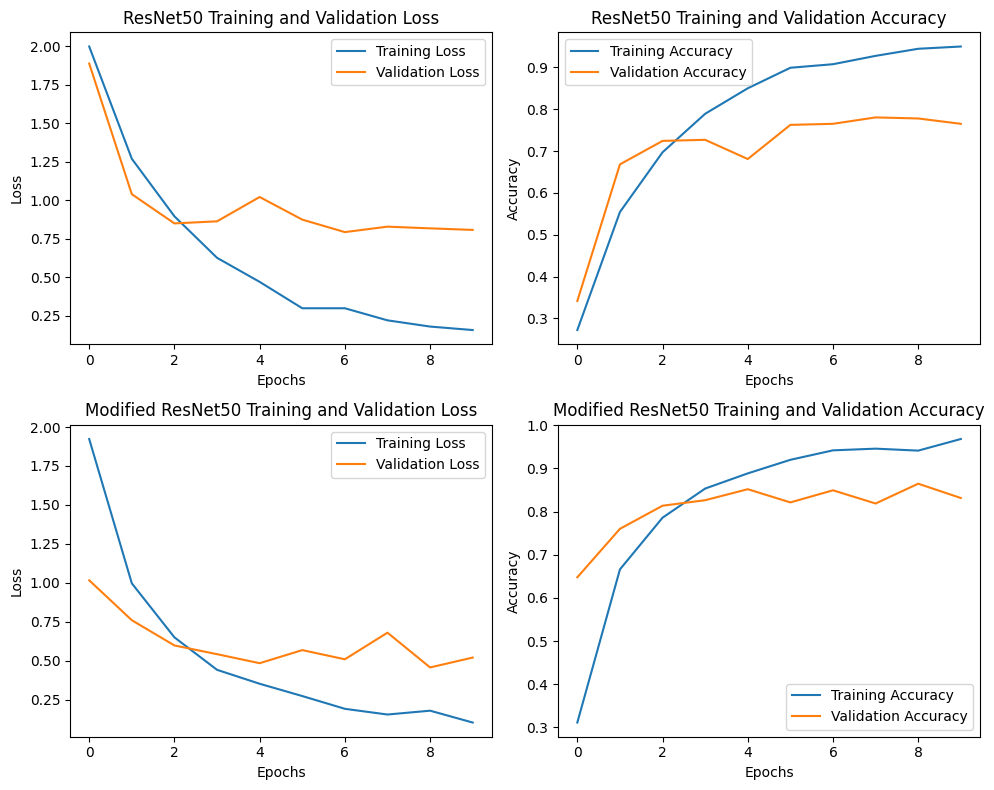

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

resnet50_result_df = pd.DataFrame(resnet50_result)
resnet50_quantizable_result_df = pd.DataFrame(resnet50_quantizable_result)

# Plot the training and validation loss curve
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for model, x in zip([resnet50_result_df, resnet50_quantizable_result_df], [0, 1]):
    axs[x, 0].plot(model['Train loss'], label='Training Loss')
    axs[x, 0].plot(model['Test loss'], label='Validation Loss')
    axs[x, 0].set(xlabel='Epochs', ylabel='Loss')
    axs[x, 0].legend(loc='best')

    axs[x, 1].plot(model['Train accuracy'], label='Training Accuracy')
    axs[x, 1].plot(model['Test accuracy'], label='Validation Accuracy')
    axs[x, 1].set(xlabel='Epochs', ylabel='Accuracy')
    axs[x, 1].legend(loc='best')

axs[0, 0].set_title('ResNet50 Training and Validation Loss')
axs[0, 1].set_title('ResNet50 Training and Validation Accuracy')
axs[1, 0].set_title('Modified ResNet50 Training and Validation Loss')
axs[1, 1].set_title('Modified ResNet50 Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [22]:
# Compare test loss, accuracy and inference time

data = [resnet50_eval, resnet50_quantizable_eval, resnet50_quantized_eval]
inference_time = [resnet50_inference_time, quantizable_inference_time, quantized_inference_time]

df = pd.DataFrame(data, columns=['Test loss', 'Test accuracy'])
df['Inference time'] = inference_time
df.index = ['ResNet50', 'Modified ResNet50', 'Quantized ResNet50']
df

,Test loss,Test accuracy,Inference time
ResNet50,0.807871,0.765306,64.545499
Modified ResNet50,0.519621,0.831633,65.468413
Quantized ResNet50,0.528367,0.839286,40.018281


In [23]:
# Compare size in MB

save_dir = './save_models'

for model in os.listdir(save_dir):
  size = os.path.getsize(os.path.join(save_dir, model))/1e6
  print(f"Size of {model}: {size:.4f} MB")

Size of resnet50_trained.pt: 94.4297 MB
Size of resnet50_quantizable_trained.pt: 94.4353 MB
Size of resnet50_quantized.pt: 24.5344 MB


# References